In [ ]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from itertools import chain

# Load the dataset
movies = pd.read_csv("movies_metadata.csv")

# Preview the dataset
print(movies.head())

C:\Users\Jayoda Kulatunga\AppData\Local\Temp\ipykernel_1764\3978960224.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("movies_metadata.csv")


   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

Step 1: Data Wrangling and Cleaning

In [6]:
# Remove rows with invalid or missing IDs
movies = movies[movies['id'].notna() & (movies['id'] != "")]

# Convert 'budget' and 'revenue' columns to numeric, replacing non-numeric values with NaN
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
movies['revenue'] = pd.to_numeric(movies['revenue'], errors='coerce')


In [7]:
# Filter out rows with zero or missing budget and revenue
movies = movies[(movies['budget'].notna()) & (movies['budget'] > 0) &
                (movies['revenue'].notna()) & (movies['revenue'] > 0)]

# Handle release_date: Extract year from release_date
movies['release_year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year
movies = movies[(movies['release_year'].notna()) & (movies['release_year'] <= 2017)]

In [8]:
# Step 1: Extract genres into a list of lists
movies['genres'] = movies['genres'].apply(lambda x: re.findall(r"'name': '(.*?)'", x))

# Step 2: Explode the list of genres into separate rows
movies = movies.explode('genres')

# Step 3: Clean the  genre strings (if necessary)
movies['genres'] = movies['genres'].str.replace("'name': |'", "", regex=True)

# Step 4: Preview cleaned data
print(movies.describe(include='all'))

        adult                              belongs_to_collection  \
count   14020                                               3432   
unique      1                                                637   
top     False  {'id': 645, 'name': 'James Bond Collection', '...   
freq    14020                                                 80   
mean      NaN                                                NaN   
std       NaN                                                NaN   
min       NaN                                                NaN   
25%       NaN                                                NaN   
50%       NaN                                                NaN   
75%       NaN                                                NaN   
max       NaN                                                NaN   

              budget genres                           homepage     id  \
count   1.402000e+04  14008                               5066  14020   
unique           NaN     20          

Step 2: Data Transformation

In [9]:
# Create a new column for ROI (Return on Investment)
movies['ROI'] = (movies['revenue'] - movies['budget']) / movies['budget']

# Group by genre to calculate average revenue, budget, and ROI
genre_summary = (
    movies.groupby('genres')
    .agg(
        avg_revenue=('revenue', 'mean'),
        avg_budget=('budget', 'mean'),
        avg_ROI=('ROI', 'mean'),
        movie_count=('genres', 'count')
    )
    .reset_index()
    .sort_values(by='avg_revenue', ascending=False)
)

print(genre_summary)

             genres   avg_revenue    avg_budget       avg_ROI  movie_count
2         Animation  2.236707e+08  6.349736e+07      5.757335          293
1         Adventure  2.044798e+08  6.375163e+07   1066.829702          960
8           Fantasy  1.987378e+08  6.190066e+07      4.955176          511
7            Family  1.950257e+08  5.785039e+07   1919.080575          532
15  Science Fiction  1.521314e+08  5.231169e+07      4.275493          635
0            Action  1.389574e+08  4.970629e+07    724.546465         1415
17         Thriller  8.382967e+07  3.235769e+07    670.044649         1504
3            Comedy  8.349717e+07  2.825436e+07   8363.088789         1852
18              War  7.696948e+07  3.172936e+07  20579.723739          204
13          Mystery  7.534317e+07  2.951166e+07     41.379596          443
4             Crime  6.988075e+07  2.798376e+07  14384.760331          862
14          Romance  6.678457e+07  2.137242e+07  13248.497917         1015
12            Music  6.66

Step 3: Data Analysis and Visualization

C:\Users\Jayoda Kulatunga\AppData\Local\Temp\ipykernel_1764\841926235.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


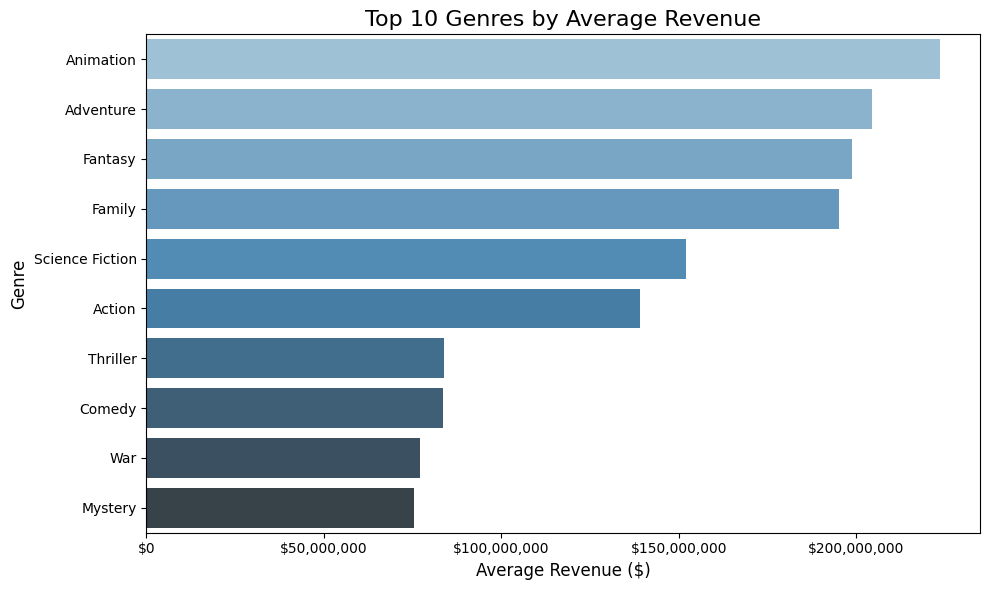

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `genre_summary` is a DataFrame with 'avg_revenue' as a string column
# Convert 'avg_revenue' to numeric
genre_summary['avg_revenue'] = pd.to_numeric(genre_summary['avg_revenue'], errors='coerce')

# Sort and select the top 10 genres by average revenue
top_10_genres = genre_summary.nlargest(10, 'avg_revenue')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_genres,
    x='avg_revenue',
    y=top_10_genres['genres'].str.strip(),  # Ensure genres are stripped of whitespace
    palette='Blues_d'
)

plt.title('Top 10 Genres by Average Revenue', fontsize=16)
plt.xlabel('Average Revenue ($)', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))  # Format y-axis as dollars

plt.tight_layout()
plt.show()


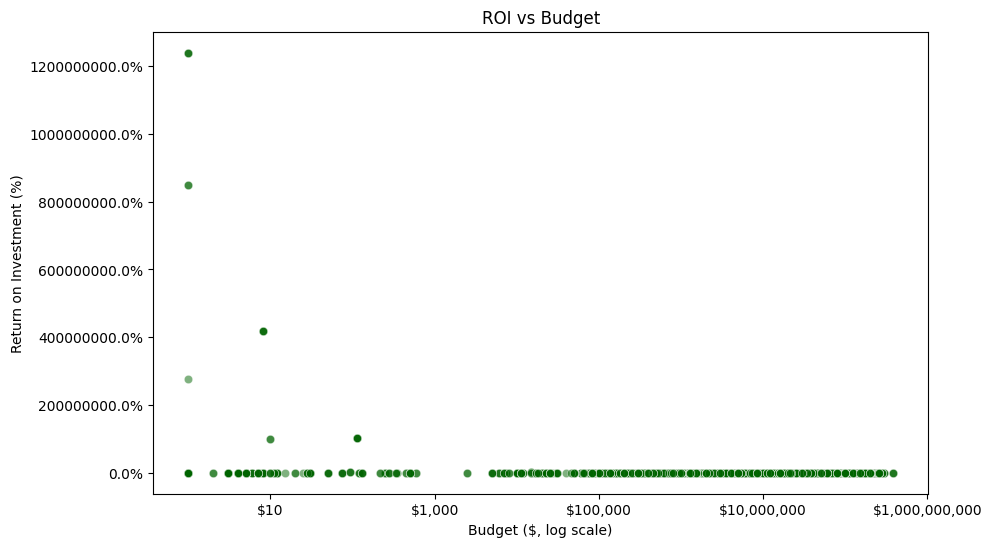

In [13]:
from matplotlib.ticker import FuncFormatter

# Define dollar and percentage formatters
def dollar(x, pos):
    return f"${x:,.0f}"

def percent(x, pos):
    return f"{x*100:.1f}%"

# Create the scatter plot
plt.figure(figsize=(10, 6))

sns.scatterplot(data=movies, x='budget', y='ROI', alpha=0.5, color='darkgreen')

# Apply log scale to the x-axis and format the axis labels
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(FuncFormatter(dollar))

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(FuncFormatter(percent))

# Set labels and title
plt.title('ROI vs Budget')
plt.xlabel('Budget ($, log scale)')
plt.ylabel('Return on Investment (%)')

# Display the plot
plt.show()


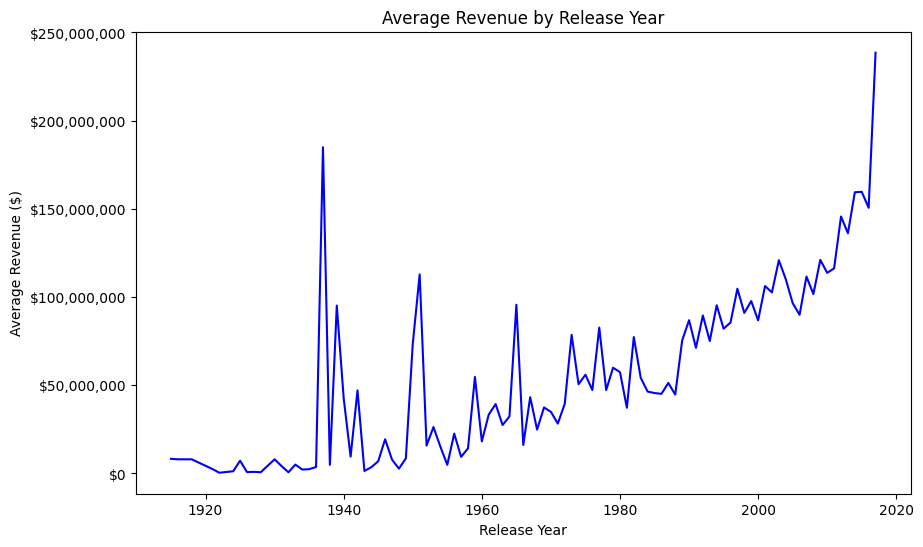

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Group by 'release_year' and calculate the average revenue
avg_revenue = movies.groupby('release_year')['revenue'].mean().reset_index()

# Define a custom formatter to display revenue in dollars
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='release_year', y='revenue', data=avg_revenue, color='blue')

# Customize the plot
plt.title('Average Revenue by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average Revenue ($)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(dollar_format))

# Show the plot
plt.show()


Step 4: Save Cleaned Data

In [15]:
import pandas as pd

# Assuming 'movies' and 'genre_summary' are DataFrames
movies.to_csv("cleaned_movies_data.csv", index=False)
# Export the genre summary
genre_summary.to_csv("genre_summary.csv", index=False)

# Print completion message
print("Data cleaning, analysis, and visualization complete. Cleaned data and summaries saved.")


Data cleaning, analysis, and visualization complete. Cleaned data and summaries saved.


cleaned_movies_data.csv

In [ ]:
# adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year,ROI
# False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000.0,Animation,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,11.4518011
# False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000.0,Comedy,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,11.4518011
# False,"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",30000000.0,Family,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,11.4518011
# False,,65000000.0,Adventure,,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,3.0430346
# False,,65000000.0,Fantasy,,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,3.0430346
# False,,65000000.0,Family,,8844,tt0113497,en,Jumanji,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,3.0430346
# False,,16000000.0,Comedy,,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the women are holding their breath, waiting for the elusive ""good man"" to break a string of less-than-stellar lovers. Friends and confidants Vannah, Bernie, Glo and Robin talk it all out, determined to find a better way to breathe.",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,"[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself... and never let you forget it.,Waiting to Exhale,False,6.1,34.0,1995,4.09075975


genre_summary.csv

In [ ]:
# genres,avg_revenue,avg_budget,avg_ROI,movie_count
# Animation,223670714.17406145,63497364.61774744,5.757334922558132,293
# Adventure,204479843.35208333,63751627.89375,1066.829702199587,960
# Fantasy,198737788.4520548,61900663.04109589,4.955176479643468,511
# Family,195025707.64285713,57850385.91165414,1919.080575210795,532
# Science Fiction,152131370.38267717,52311694.207874015,4.275493090960649,635
# Action,138957422.3745583,49706290.234628975,724.5464652749253,1415
# Thriller,83829667.14494681,32357693.717420213,670.0446485242521,1504
# Comedy,83497171.59071274,28254364.43088553,8363.08878925378,1852
# War,76969483.88725491,31729359.87254902,20579.72373866759,204
# Mystery,75343166.51241535,29511659.532731377,41.3795962966964,443
# Crime,69880748.86078887,27983761.42691415,14384.76033064096,862
# Romance,66784573.28472906,21372420.772413794,13248.49791716782,1015
# Music,66616619.041666664,19923966.916666668,4.970629180506783,192
# History,61931947.50212766,30050227.64680851,17873.90665178131,235
# Drama,57893284.6810978,22369561.067645922,10110.152678968616,2587
# Western,54520312.43820225,29583280.61797753,3.2065499435312956,89
# Horror,50859133.539249144,16375528.564846417,1745.9469794713198,586
# TV Movie,42000000.0,5000000.0,7.4,1
# Documentary,17556358.288135592,4316854.491525424,104.99719628822889,59
# Foreign,4193511.090909091,3631379.787878788,2.158545382536619,33
